### in the name of Allah
# Shopping Basket Analysis and Recommender System based on ARM (Association Rule Mining)
------------------
## TASK I: Data Preprocessing

This task focuses on preparing the Instacart e-commerce dataset for Association Rule Mining analysis. The preprocessing pipeline ensures data quality and creates a manageable subset for efficient pattern mining. We address common data issues including missing values and irrelevant transactions, while focusing on multi-item baskets essential for meaningful association rule discovery. By sampling 20,000 users, we balance computational feasibility with sufficient data coverage for robust analysis.

### **Step 1: Loading the Data**
Load CSV files:
- **pandas** for small files: `aisles.csv`, `departments.csv`, `products.csv`
- **dask** for large files: `order_products__train.csv`, `orders.csv`, `order_products__prior.csv`

### **Step 2: Data Cleaning Functions**
Define functions:
- **`remove_nulls(df)`**: Remove rows with missing values.
- **`filter_single_item_orders(df)`**: Remove orders with only one product.
- **`filter_by_order_ids(df, order_ids_set)`**: Filter by order IDs.

### **Step 3: Preprocessing Execution**
1. **Remove nulls** from all tables.
2. **Remove single-item orders** from order products data.
3. **Sample 20,000 users** randomly from orders.
4. **Extract orders** for sampled users.
5. **Filter order products** to include only sampled orders.

### **Step 4: Saving Cleaned Data**
Save cleaned data to `./processed_data/`:
- **`aisles_cleaned.csv`**, **`products_cleaned.csv`**, **`departments_cleaned.csv`**
- **`orders_sampled.csv`**: Orders of 20,000 sampled users.
- **`order_products_train_sampled.csv`**, **`order_products_prior_sampled.csv`**
- **`order_products_combined.csv`**: Combined data for basket analysis.

This preprocessing ensures clean, multi-item basket data ready for Association Rule Mining in subsequent tasks.

In [ ]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# ============================================================================
# LOADING DATA FROM CSV FILES
# ============================================================================

# Load small metadata files using pandas
aisles = pd.read_csv('aisles.csv')
products = pd.read_csv('products.csv')
departments = pd.read_csv('departments.csv')

# Load large transactional files using dask
orders = dd.read_csv('orders.csv')
order_products_train = dd.read_csv('order_products__train.csv')
order_products_prior = dd.read_csv('order_products__prior.csv')

print("Data loading completed.")
print(f"Orders: {orders.shape[0].compute():,} rows")
print(f"Order Products Prior: {order_products_prior.shape[0].compute():,} rows")
print(f"Order Products Train: {order_products_train.shape[0].compute():,} rows")

Data loading completed.
Orders: 3,421,083 rows
Order Products Prior: 32,434,489 rows
Order Products Train: 1,384,617 rows


In [2]:
# ============================================================================
# DATA PREPROCESSING FUNCTIONS
# ============================================================================

def remove_nulls(df):
    """Remove rows with null values from dataframe."""
    return df.dropna()


def filter_single_item_orders(df):
    """
    Remove orders that contain only one product item.
    For basket analysis, we need at least two items per order.
    """
    # Count products per order using groupby and size
    item_counts = df.groupby('order_id').size().reset_index()
    item_counts = item_counts.rename(columns={0: 'item_count'})
    
    # Get orders with more than 1 item & filter original dataframe
    multi_item_orders = item_counts[item_counts['item_count'] > 1]
    return df[df['order_id'].isin(multi_item_orders['order_id'])]


def filter_by_order_ids(df, order_ids_set):
    """
    Filter dataframe based on a set of order_ids
    >>> used for 2000 selected users.
    """
    return df[df['order_id'].isin(order_ids_set)]

In [3]:
# ============================================================================
# DATA PREPROCESSING EXECUTION
# ============================================================================

print("\n" + "="*50)
print("TASK 1: DATA PREPROCESSING")
print("="*50)

# Step 1: Remove null values
print("\n1. Removing null values...")
aisles_cleaned = remove_nulls(aisles)
products_cleaned = remove_nulls(products)
departments_cleaned = remove_nulls(departments)
orders_cleaned = remove_nulls(orders).persist()
order_products_train_cleaned = remove_nulls(order_products_train).persist()
order_products_prior_cleaned = remove_nulls(order_products_prior).persist()

# Step 2: Remove single-item orders
print("2. Removing single-item orders...")
order_products_train_filtered = filter_single_item_orders(order_products_train_cleaned).persist()
order_products_prior_filtered = filter_single_item_orders(order_products_prior_cleaned).persist()

# Step 3: Sample 20,000 users
print("3. Sampling 20,000 random users...")
unique_users_count = orders_cleaned['user_id'].nunique().compute()
frac_value = min(20000 / unique_users_count, 1.0)

sampled_users = orders_cleaned['user_id'].drop_duplicates().sample(
    frac=frac_value, 
    random_state=42
)

# Step 4: Get orders for sampled users
sampled_users_list = sampled_users.compute().tolist()
orders_sampled = orders_cleaned[orders_cleaned['user_id'].isin(sampled_users_list)]

# Get order IDs
sampled_order_ids = orders_sampled['order_id'].compute().tolist()
order_ids_set = set(sampled_order_ids)

# Step 5: Filter order products
print("4. Filtering order products...")
order_products_train_sampled = order_products_train_filtered.map_partitions(
    filter_by_order_ids, 
    order_ids_set,
    meta=order_products_train_filtered._meta
).persist()

order_products_prior_sampled = order_products_prior_filtered.map_partitions(
    filter_by_order_ids,
    order_ids_set,
    meta=order_products_prior_filtered._meta
).persist()

print("\nPreprocessing completed!")


TASK 1: DATA PREPROCESSING

1. Removing null values...
2. Removing single-item orders...
3. Sampling 20,000 random users...
4. Filtering order products...

Preprocessing completed!


In [4]:
# ============================================================================
# SAVING PROCESSED DATA
# ============================================================================

output_folder = './processed_data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
print(f"\nSaving data to {output_folder}/")

# Save metadata files
aisles_cleaned.to_csv(f'{output_folder}/aisles_cleaned.csv', index=False)
products_cleaned.to_csv(f'{output_folder}/products_cleaned.csv', index=False)
departments_cleaned.to_csv(f'{output_folder}/departments_cleaned.csv', index=False)

# Save transactional data (need to compute dask dataframes first)
orders_sampled_computed = orders_sampled.compute()
orders_sampled_computed.to_csv(f'{output_folder}/orders_sampled.csv', index=False)

order_products_train_sampled_computed = order_products_train_sampled.compute()
order_products_train_sampled_computed.to_csv(
    f'{output_folder}/order_products_train_sampled.csv', 
    index=False
)

order_products_prior_sampled_computed = order_products_prior_sampled.compute()
order_products_prior_sampled_computed.to_csv(
    f'{output_folder}/order_products_prior_sampled.csv', 
    index=False
)

# Save combined data for basket analysis
order_products_combined = dd.concat([order_products_train_sampled, order_products_prior_sampled])
order_products_combined_computed = order_products_combined.compute()
order_products_combined_computed.to_csv(
    f'{output_folder}/order_products_combined.csv', 
    index=False
)

# Final summary
print("\n" + "="*50)
print("TASK 1 SUMMARY")
print("="*50)
print(f"Sampled users: {len(sampled_users_list):,}")
print(f"Sampled orders: {orders_sampled_computed.shape[0]:,}")
print(f"Total products for basket analysis: {order_products_combined_computed.shape[0]:,}")
print("\n✓ Task 1 completed - Data ready for basket analysis (Task 2)")
print("="*50)


Saving data to ./processed_data/

TASK 1 SUMMARY
Sampled users: 20,000
Sampled orders: 312,778
Total products for basket analysis: 3,083,695

✓ Task 1 completed - Data ready for basket analysis (Task 2)


## TASK II: Basket Encoding for Association Rule Mining

This task transforms the cleaned transactional data into a binary matrix format suitable for Association Rule Mining algorithms like Apriori. We convert order-level product lists into a one-hot encoded representation, focusing on frequently purchased products to reduce dimensionality and computational complexity. The process ensures that only meaningful multi-item baskets are retained for pattern discovery.

### **Step 1: Loading Processed Data**
Load the combined order products data and product mappings from Task 1:
- `order_products_combined.csv`: Contains order-product pairs.
- `products_cleaned.csv`: Provides product ID to name mappings.

### **Step 2: Creating Shopping Baskets**
Group products by order ID to form shopping baskets:
- Each basket represents a list of products purchased together in a single order.
- This step converts transactional data into a basket format essential for market basket analysis.

### **Step 3: One-Hot Encoding & Product Filtering**
1. **Identify Unique Products:** Extract all unique products across baskets.
2. **Filter Frequent Products:** Retain only products that appear in at least 0.5% of baskets to focus on significant items and reduce noise.
3. **Build Binary Matrix:** Create a boolean matrix where rows correspond to baskets and columns to filtered products. A value of `True` indicates the presence of a product in a basket.
4. **Remove Sparse Baskets:** Discard baskets with fewer than 2 products to ensure meaningful associations.

### **Step 4: Saving the Encoded Matrix**
- Save the final binary matrix as `basket_encoded.csv` for use in subsequent association rule mining tasks. This matrix optimizes memory usage and computational efficiency for the Apriori algorithm.
- This encoding step transforms raw transactional data into a structured format ready for frequent itemset mining and association rule generation.

In [39]:
# ============================================================================
# LOADING PROCESSED DATA (FROM TASK1)
# ============================================================================

# Load order products data
order_products = pd.read_csv('./processed_data/order_products_combined.csv')

# Load products for mapping IDs to names
products = pd.read_csv('./processed_data/products_cleaned.csv')

print(f"Order products: {order_products.shape[0]:,} rows")
print(f"Unique orders: {order_products['order_id'].nunique():,}")
print(f"Unique products: {order_products['product_id'].nunique():,}")

Order products: 3,083,695 rows
Unique orders: 290,898
Unique products: 41,001


In [40]:
# ============================================================================
# CREATING SHOPPING BASKETS
# ============================================================================

# Group by order_id to create product lists
baskets = order_products.groupby('order_id')['product_id'].apply(list).reset_index(name='products')

print(f"Total baskets created: {len(baskets):,}")
print(f"Avg items per basket: {baskets['products'].apply(len).mean():.2f}")

# Prepare transactions for one-hot encoding
transactions = baskets['products'].tolist()

Total baskets created: 290,898
Avg items per basket: 10.60


In [41]:
# ============================================================================
# CREATING ONE-HOT ENCODED MATRIX
# ============================================================================

# Get unique products and filter frequent ones
all_products = np.unique(np.concatenate(transactions))
print(f"Unique products: {len(all_products):,}")

# Count product frequencies
product_counts = np.zeros(len(all_products), dtype=np.int32)
for transaction in transactions:
    indices = np.searchsorted(all_products, transaction)
    product_counts[indices] += 1

# Filter products (keep top 0.5%)
threshold = int(len(transactions) * 0.005)
frequent_mask = product_counts >= threshold
frequent_products = all_products[frequent_mask]
print(f"Products after filtering: {len(frequent_products):,}")

# Create product to index mapping
product_to_idx = {prod: idx for idx, prod in enumerate(frequent_products)}

# Build binary matrix
n_baskets = len(transactions)
n_products = len(frequent_products)
binary_matrix = np.zeros((n_baskets, n_products), dtype=np.bool_)

for i, transaction in enumerate(transactions):
    for prod in transaction:
        if prod in product_to_idx:
            binary_matrix[i, product_to_idx[prod]] = True

# Remove carts with less than 2 products
row_sums = binary_matrix.sum(axis=1)
binary_matrix = binary_matrix[row_sums >= 2]
print(f"After removing baskets with <2 items: {binary_matrix.shape[0]:,} baskets")

Unique products: 41,001
Products after filtering: 273
After removing baskets with <2 items: 197,016 baskets


In [42]:
# ============================================================================
# CREATE & SAVE DATAFRAME
# ============================================================================

basket_encoded = pd.DataFrame(
    binary_matrix, 
    columns=[f"Product_{p}" for p in frequent_products]
)

print(f"Binary matrix shape: {basket_encoded.shape}")
print(f"Memory usage: {binary_matrix.nbytes / 1024**3:.2f} GB")

# Save
basket_encoded.to_csv('./processed_data/basket_encoded.csv', index=False)
print("Saved: basket_encoded.csv")

print("\n" + "="*50)
print("TASK 2 SUMMARY")
print("="*50)
print(f"Original baskets: {len(baskets):,}")
print(f"Final baskets: {basket_encoded.shape[0]:,}")
print(f"Products after filtering: {basket_encoded.shape[1]}")
print(f"Matrix shape: {basket_encoded.shape}")
print("\n✓ Task 2 completed")
print("="*50)

Binary matrix shape: (197016, 273)
Memory usage: 0.05 GB
Saved: basket_encoded.csv

TASK 2 SUMMARY
Original baskets: 290,898
Final baskets: 197,016
Products after filtering: 273
Matrix shape: (197016, 273)

✓ Task 2 completed


## TASK III: Frequent Itemset Mining with Apriori Algorithm

This task implements the Apriori algorithm to discover frequent itemsets from the encoded basket data. We systematically explore different minimum support thresholds to understand their impact on the mining results, enabling data-driven parameter selection for optimal association rule discovery.

### **Step 1: Parameter Exploration**
Execute Apriori algorithm across multiple minimum support values (0.05 to 0.01) to analyze sensitivity:
- **Higher support (0.05-0.035)**: Produces only single-item sets (14-25 itemsets).
- **Critical threshold (0.03)**: First appearance of 2-item sets (39 itemsets).
- **Optimal range (0.025-0.01)**: Balanced quantity and quality (59-212 itemsets).

### **Step 2: Visual Analysis**
Generate comparative visualizations:
- **Total Itemsets vs Minimum Support**: Inverse relationship showing exponential growth in itemset count as support decreases.
- **Maximum Itemset Size vs Minimum Support**: Step function revealing the support threshold (0.03) where 2-item sets emerge.

### **Step 3: Optimal Parameter Selection**
Based on analysis, select min_support = 0.025 as optimal balance point:
1. **59 frequent itemsets** identified
2. **Size distribution**: 54 single-item sets (91.5%) + 5 two-item sets (8.5%)
3. **Top performers**: Product_24852 (20.94% support), Product_13176 (17.01%), Product_21137 (12.43%)

### **Step 4: Results Storage**
- Save complete frequent itemsets to `frequent_itemsets_0025.csv` for use in association rule generation. This dataset forms the foundation for deriving meaningful product association rules in Task 4.
- This systematic parameter exploration ensures robust selection of mining parameters, balancing computational efficiency with comprehensive pattern discovery for actionable business insights.

In [43]:
# ============================================================================
# RUNNING APRIORI WITH DIFFERENT MIN SUPPORT VALUES
# ============================================================================

# Start with higher min_support values first
min_support_values = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01]
results = []

for min_sup in min_support_values:
    print(f"Testing min_support={min_sup:.3f}...")
    
    try:
        # Use low_memory=True to reduce memory usage
        frequent_itemsets = apriori(
            basket_encoded, 
            min_support=min_sup,
            use_colnames=True,
            max_len=None,
            low_memory=True 
        )
        
        total_itemsets = len(frequent_itemsets)
        if total_itemsets > 0:
            max_size = frequent_itemsets['itemsets'].apply(len).max()
        else:
            max_size = 0
        
        results.append({
            'min_support': min_sup,
            'total_itemsets': total_itemsets,
            'max_itemset_size': max_size
        })
        
        print(f"  ✓ Found {total_itemsets:,} itemsets (max size: {max_size})")
        
    except MemoryError:
        print(f"  ✗ MemoryError at min_support={min_sup:.3f}")
        results.append({
            'min_support': min_sup,
            'total_itemsets': -1,
            'max_itemset_size': -1
        })
        break 

# Create results dataframe
results_df = pd.DataFrame(results)
print("\nResults summary:")
print(results_df.to_string())

Testing min_support=0.050...
  ✓ Found 14 itemsets (max size: 1)
Testing min_support=0.045...
  ✓ Found 15 itemsets (max size: 1)
Testing min_support=0.040...
  ✓ Found 20 itemsets (max size: 1)
Testing min_support=0.035...
  ✓ Found 25 itemsets (max size: 1)
Testing min_support=0.030...
  ✓ Found 39 itemsets (max size: 2)
Testing min_support=0.025...
  ✓ Found 59 itemsets (max size: 2)
Testing min_support=0.020...
  ✓ Found 76 itemsets (max size: 2)
Testing min_support=0.015...
  ✓ Found 120 itemsets (max size: 2)
Testing min_support=0.010...
  ✓ Found 212 itemsets (max size: 2)

Results summary:
   min_support  total_itemsets  max_itemset_size
0        0.050              14                 1
1        0.045              15                 1
2        0.040              20                 1
3        0.035              25                 1
4        0.030              39                 2
5        0.025              59                 2
6        0.020              76                 2
7  

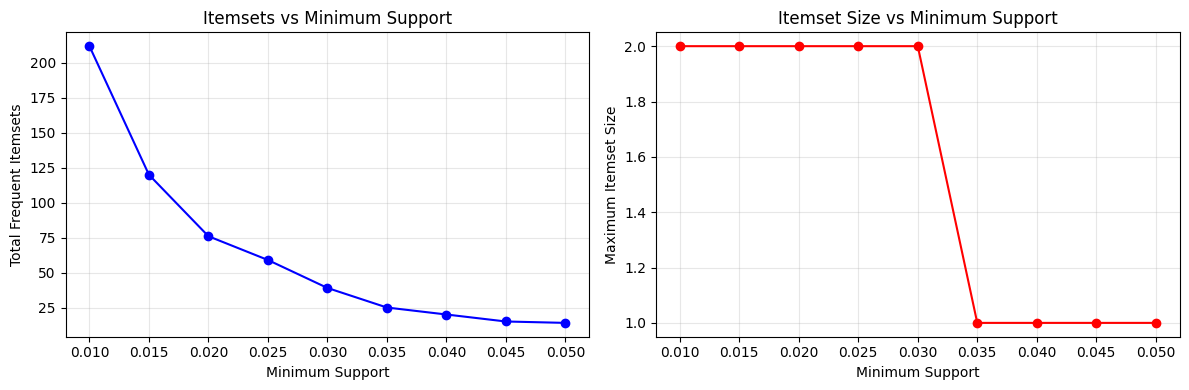

Saved: apriori_comparison.png


In [44]:
# ============================================================================
# CREATING COMPARISON PLOTS
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Total itemsets vs min_support
ax1.plot(results_df['min_support'], results_df['total_itemsets'], 'b-o')
ax1.set_xlabel('Minimum Support')
ax1.set_ylabel('Total Frequent Itemsets')
ax1.set_title('Itemsets vs Minimum Support')
ax1.grid(True, alpha=0.3)

# Plot 2: Max itemset size vs min_support
ax2.plot(results_df['min_support'], results_df['max_itemset_size'], 'r-o')
ax2.set_xlabel('Minimum Support')
ax2.set_ylabel('Maximum Itemset Size')
ax2.set_title('Itemset Size vs Minimum Support')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./processed_data/apriori_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: apriori_comparison.png")

In [45]:
# ============================================================================
# RUNNING APRIORI WITH MIN_SUPPORT = 0.025 (selected as optimal based on above analysis)
# ============================================================================

# Run Apriori with specified min_support
frequent_itemsets_025 = apriori(
    basket_encoded, 
    min_support=0.025,
    use_colnames=True,
    max_len=None
)

# Add itemset length
frequent_itemsets_025['length'] = frequent_itemsets_025['itemsets'].apply(len)
print(f"Found {len(frequent_itemsets_025):,} frequent itemsets with min_support=0.025")

# Show distribution
print("\nItemset size distribution:")
size_dist = frequent_itemsets_025['length'].value_counts().sort_index()
for size, count in size_dist.items():
    print(f"  Size {size}: {count:,} itemsets")

# Show top 10 itemsets
print("\nTop 10 frequent itemsets by support:")
top_10 = frequent_itemsets_025.nlargest(10, 'support')

# Create product name mapping
product_names = products.set_index('product_id')['product_name'].to_dict()
for idx, row in top_10.iterrows():
    items = list(row['itemsets'])
    item_names = [product_names.get(item, f"Product_{item}") for item in items]
    print(f"  Support: {row['support']:.4f} - {', '.join(item_names[:2])}{'...' if len(item_names) > 2 else ''}")

# Save results
frequent_itemsets_025.to_csv('./processed_data/frequent_itemsets_0025.csv', index=False)
print("\nSaved: frequent_itemsets_0025.csv")

# Final summary
print("\n" + "="*50)
print("TASK 3 SUMMARY")
print("="*50)
print(f"Frequent itemsets with min_support=0.025: {len(frequent_itemsets_025):,}")
print(f"Itemset size distribution: {dict(size_dist)}")
print("\n✓ Task 3 completed - Frequent itemsets generated for association rules")
print("="*50)

Found 59 frequent itemsets with min_support=0.025

Itemset size distribution:
  Size 1: 54 itemsets
  Size 2: 5 itemsets

Top 10 frequent itemsets by support:
  Support: 0.2094 - Product_Product_24852
  Support: 0.1701 - Product_Product_13176
  Support: 0.1243 - Product_Product_21137
  Support: 0.1104 - Product_Product_21903
  Support: 0.0985 - Product_Product_47209
  Support: 0.0820 - Product_Product_47766
  Support: 0.0742 - Product_Product_47626
  Support: 0.0670 - Product_Product_26209
  Support: 0.0662 - Product_Product_27966
  Support: 0.0636 - Product_Product_16797

Saved: frequent_itemsets_0025.csv

TASK 3 SUMMARY
Frequent itemsets with min_support=0.025: 59
Itemset size distribution: {1: np.int64(54), 2: np.int64(5)}

✓ Task 3 completed - Frequent itemsets generated for association rules


## TASK IV: Association Rule Mining and Analysis

This task generates and analyzes association rules from the frequent itemsets discovered in Task 3. Using the mlxtend library's `association_rules` function, we extract meaningful relationships between products and evaluate them using key metrics including support, confidence, and lift. The analysis identifies the strongest product associations for actionable business recommendations.

### **Step 1: Loading Frequent Itemsets**
Load the precomputed frequent itemsets from Task 3:
- `frequent_itemsets_0025.csv`: Contains 59 frequent itemsets with min_support=0.025.
- Convert string representations of itemsets back to Python sets for rule generation.
- Itemset size ranges from 1 to 2, enabling discovery of pairwise product relationships.

### **Step 2: Generating and Analyzing Association Rules**
Apply the association rules algorithm with minimum confidence threshold of 0.1:
- **10 association rules** generated from the frequent itemsets.
- **All rules have lift > 1**, indicating positive relationships between products.
- **Support range**: 0.0251 to 0.0302 (2.5% to 3% of transactions).
- **Confidence range**: 0.1197 to 0.3059 (12% to 31% prediction accuracy).
- **Average lift:**: 1.358, showing moderate to strong associations.

### **Step 3: Identifying Top Rules by Lift**
Extract the three strongest association rules based on lift value:
1. **Product_13176 → Product_47209** (Lift: 1.7398, Confidence: 17.13%, Support: 2.91%)
2. **Product_47209 → Product_13176** (Lift: 1.7398, Confidence: 29.59%, Support: 2.91%)
3. **Product_47766 → Product_24852** (Lift: 1.4604, Confidence: 30.59%, Support: 2.51%)

### **Step 4: Saving Results and Final Summary**
Save the complete analysis for business implementation:
- `association_rules.csv`: All 10 generated rules with full metrics.
- `top_3_rules_by_lift.csv`: Filtered set of strongest rules for immediate action.
- **Key insight**: The bidirectional relationship between Product_13176 and Product_47209 represents the strongest association in the dataset.

This association rule mining provides actionable insights for product placement, promotional bundling, and cross-selling strategies, enabling data-driven decision making for retail optimization.

In [46]:
# ============================================================================
# LOADING FREQUENT ITEMSETS FROM TASK 3
# ============================================================================

# Load frequent itemsets from Task 3
frequent_itemsets = pd.read_csv('./processed_data/frequent_itemsets_0025.csv')

# Simple conversion using eval (only if you trust the data source)
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

print(f"Loaded {len(frequent_itemsets):,} frequent itemsets")
print(f"Itemset size range: {frequent_itemsets['length'].min()} to {frequent_itemsets['length'].max()}")

Loaded 59 frequent itemsets
Itemset size range: 1 to 2


In [47]:
# ============================================================================
# EXTRACTING & ANALYZING ASSOCIATION RULES
# ============================================================================

# Generate association rules
rules = association_rules(
    frequent_itemsets, 
    metric="confidence", 
    min_threshold=0.1
    # Other ths: 0.2, 0.3 
)

print(f"Generated {len(rules):,} association rules")
print(f"\nFirst 3 rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(3))

# Analyzing rules metrics
print("Analysis of rule metrics:")
print(f"Support range: {rules['support'].min():.4f} to {rules['support'].max():.4f}")
print(f"Confidence range: {rules['confidence'].min():.4f} to {rules['confidence'].max():.4f}")
print(f"Lift range: {rules['lift'].min():.4f} to {rules['lift'].max():.4f}")

print(f"\nAverage confidence: {rules['confidence'].mean():.4f}")
print(f"Average lift: {rules['lift'].mean():.4f}")
print(f"Rules with lift > 1: {(rules['lift'] > 1).sum():,}")

Generated 10 association rules

First 3 rules:
       antecedents      consequents  support  confidence      lift
0  (Product_13176)  (Product_21137)  0.03017    0.177375  1.427459
1  (Product_21137)  (Product_13176)  0.03017    0.242801  1.427459
2  (Product_13176)  (Product_47209)  0.02914    0.171317  1.739802
Analysis of rule metrics:
Support range: 0.0251 to 0.0302
Confidence range: 0.1197 to 0.3059
Lift range: 1.0473 to 1.7398

Average confidence: 0.2019
Average lift: 1.3580
Rules with lift > 1: 10


In [48]:
# ============================================================================
# FINDING TOP 3 RULES BY LIFT
# ============================================================================

# Convert lift column to numeric
rules['lift'] = pd.to_numeric(rules['lift'], errors='coerce')

# Get top 3 rules by lift
top_3_lift = rules.nlargest(3, 'lift')

print("Top 3 association rules by lift:")
print("=" * 50)

# Load product names for better interpretation
products = pd.read_csv('./processed_data/products_cleaned.csv')
product_names = products.set_index('product_id')['product_name'].to_dict()

for idx, row in top_3_lift.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    
    ant_names = [product_names.get(item, f"Product_{item}") for item in antecedents]
    cons_names = [product_names.get(item, f"Product_{item}") for item in consequents]
    
    print(f"\nRule {idx+1}:")
    print(f"  IF {', '.join(ant_names)}")
    print(f"  THEN {', '.join(cons_names)}")
    print(f"  Support: {row['support']:.4f}")
    print(f"  Confidence: {row['confidence']:.4f}")
    print(f"  Lift: {row['lift']:.4f}")

Top 3 association rules by lift:

Rule 3:
  IF Product_Product_13176
  THEN Product_Product_47209
  Support: 0.0291
  Confidence: 0.1713
  Lift: 1.7398

Rule 4:
  IF Product_Product_47209
  THEN Product_Product_13176
  Support: 0.0291
  Confidence: 0.2959
  Lift: 1.7398

Rule 9:
  IF Product_Product_47766
  THEN Product_Product_24852
  Support: 0.0251
  Confidence: 0.3059
  Lift: 1.4604


In [49]:
# ============================================================================
# SAVING RULES AND FINAL SUMMARY
# ============================================================================

# Save all rules to CSV
rules.to_csv('./processed_data/association_rules.csv', index=False)
print("\nSaved: association_rules.csv")

# Save top rules separately
top_3_lift.to_csv('./processed_data/top_3_rules_by_lift.csv', index=False)
print("Saved: top_3_rules_by_lift.csv")

# Final summary
print("\n" + "="*50)
print("TASK 4 SUMMARY")
print("="*50)
print(f"Total association rules generated: {len(rules):,}")
print(f"Rules with lift > 1: {(rules['lift'] > 1).sum():,}")
print(f"Top lift value: {top_3_lift['lift'].max():.4f}")
print("\n✓ Task 4 completed - Association rules extracted and analyzed")
print("="*50)


Saved: association_rules.csv
Saved: top_3_rules_by_lift.csv

TASK 4 SUMMARY
Total association rules generated: 10
Rules with lift > 1: 10
Top lift value: 1.7398

✓ Task 4 completed - Association rules extracted and analyzed
